In [1]:
import random
import math

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import tree
import joblib

import scipy

In [4]:
plt.rcParams["figure.figsize"] = (15, 17)

In [5]:
def convertFahrenheitToCelsius(f):
    return (f - 32) / 1.8

## load random forest model

In [6]:
filename_min = './min_random_forest_model.sav'
filename_max = './max_random_forest_model.sav'

In [7]:
rfr_min = joblib.load(filename_min)
rfr_max = joblib.load(filename_max)

## create test data from test dataset

In [8]:
pth_min = '../processed_data/test_min.csv'
df_min = pd.read_csv(pth_min)

In [9]:
pth_max = '../processed_data/test_max.csv'
df_max = pd.read_csv(pth_max)

In [10]:
df_min.shape

(54, 14)

In [11]:
df_max.shape

(9, 15)

In [12]:
df_combine = pd.concat([df_min, df_max])

In [13]:
df_combine

,Unnamed: 0,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act,env_temp,pmv_temp_max
0,166,1.77,68.0,-1.0,21.705129,24.0,57.779,76.298872,23.987342,31.672874,0.877379,0.54,1.0,78.514,NaN
1,25,1.83,74.0,-1.0,22.096808,24.0,46.650,84.000000,23.987342,31.693000,0.009496,0.50,1.1,79.502,NaN
2,229,1.63,50.0,1.0,18.818924,23.0,41.050,86.000000,23.987342,30.563000,0.281910,0.50,1.0,76.354,NaN
3,217,1.63,50.0,1.0,18.818924,23.0,39.170,67.000000,7.000000,31.672874,0.059989,0.50,1.0,74.964,NaN
4,71,1.69,75.0,-1.0,26.259585,24.0,28.920,102.000000,23.987342,31.672874,0.002888,0.36,1.1,74.619,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,43,1.77,58.0,-1.0,18.513199,23.0,51.234,102.500000,78.000000,33.636000,0.585949,0.36,1.3,80.272,30.7
5,26,1.60,52.5,1.0,20.507812,24.0,51.538,88.158537,62.485294,32.559814,-0.100261,0.53,1.0,72.696,30.6
6,6,1.77,58.0,-1.0,18.513199,23.0,55.272,87.000000,62.485294,32.915000,0.006857,0.36,1.0,79.480,32.0
7,8,1.77,90.0,-1.0,28.727377,28.0,60.389,67.000000,62.485294,31.013000,0.188456,0.36,1.1,79.480,30.7


In [14]:
X_columns = ['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
              'heart_rate', 'stress_level', 'skin_temp', 'eda', \
              'Clo', 'Act']

In [15]:
X = df_combine[X_columns]
y = df_combine['env_temp']

## predict

### predict comfort zone min value

In [16]:
y_pred_min = rfr_min.predict(X)

### transfer to Celsius

In [17]:
y_pred_min = np.array([convertFahrenheitToCelsius(f) for f in y_pred_min])

In [18]:
y_pred_min

array([25.48497639, 25.37197292, 24.39942986, 24.25662778, 24.22549931,
       23.73016944, 24.47877153, 24.95991944, 24.69227917, 24.78456667,
       24.02832431, 24.35699236, 24.82526736, 24.69630278, 23.96453264,
       23.98368611, 24.43206528, 24.02250903, 23.4535375 , 25.15176181,
       23.89805278, 23.6700625 , 25.21150556, 24.00911181, 24.02572986,
       24.88604722, 22.90857292, 24.39703681, 25.33293056, 24.61473333,
       24.07509722, 24.95213472, 23.86252639, 24.81080486, 24.05384028,
       24.09036042, 24.646275  , 23.13148194, 24.15849097, 24.33471597,
       24.29256042, 22.57400069, 24.56658194, 24.08756042, 24.28873403,
       24.66696319, 25.37199792, 23.73875486, 24.93189514, 24.71713403,
       23.75675   , 24.09079236, 24.08004722, 24.77542292, 25.83106736,
       25.95973125, 25.44440625, 23.84662153, 25.33325347, 24.23304792,
       24.85243194, 24.02317708, 25.38571319])

### predict comfort zone max value

In [19]:
y_pred_max = rfr_max.predict(X)

### transfer to Celsius

In [20]:
y_pred_max = np.array([convertFahrenheitToCelsius(f) for f in y_pred_max])

In [21]:
y_pred_max

array([26.76702815, 28.57730148, 25.68293889, 25.45968296, 27.23483963,
       25.90016222, 26.14875481, 25.90394815, 26.12800185, 25.75053185,
       27.28443333, 25.67265963, 27.25235667, 26.14587222, 26.42879296,
       25.7917937 , 27.1870137 , 27.25681407, 25.47246222, 27.09418   ,
       25.45574556, 25.49398296, 26.48346519, 25.65910667, 27.25977852,
       26.50743593, 25.73104185, 27.18660778, 25.36556519, 26.41513259,
       25.63090926, 25.1567537 , 25.17823037, 26.18545481, 25.42472444,
       25.51269593, 26.42793148, 25.79203815, 25.51347074, 26.88564037,
       25.51338407, 25.58147556, 25.83430593, 27.30930037, 26.20416074,
       26.35091407, 26.56321815, 27.30116333, 25.29167407, 26.23136593,
       26.44841741, 25.52892481, 25.34989852, 26.00658259, 26.38098667,
       27.14169259, 25.99573852, 26.96327   , 26.89413704, 24.80595074,
       26.07075704, 26.75300185, 26.03961778])

### detect error

In [22]:
errorIdx = []
for i in range(len(y_pred_min)):
    if y_pred_max[i] <= y_pred_min[i]:
        errorIdx.append(i)

In [23]:
errorIdx

[]

In [24]:
df_combine.iloc[errorIdx,:]

,Unnamed: 0,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act,env_temp,pmv_temp_max


### delete the unacceptable values

In [25]:
t_min = []
t_max = []
for i in range(len(y_pred_min)):
    if y_pred_min[i] <= y_pred_max[i]:
        t_min.append(y_pred_min[i])
        t_max.append(y_pred_max[i])
    else:
        t_min.append(y_pred_min[i])
        t_max.append(y_pred_min[i])

In [26]:
len(t_min)

63

### plot zone

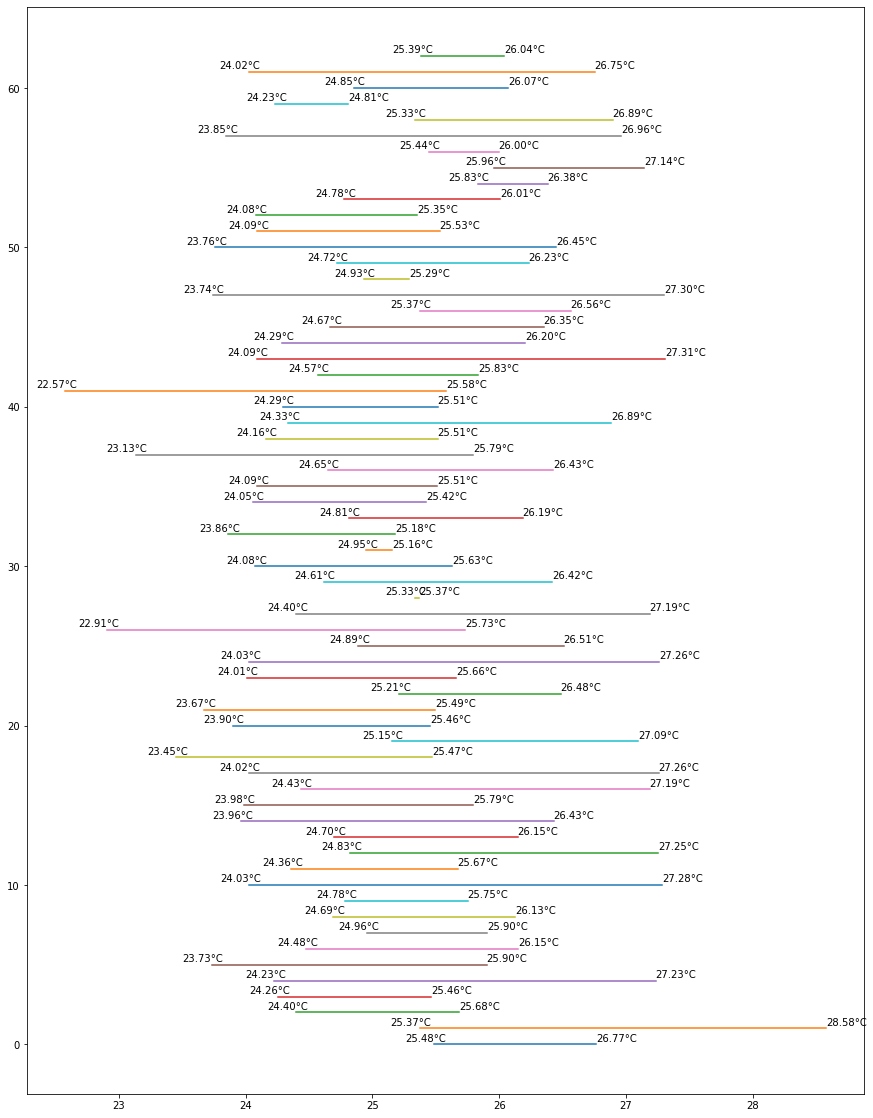

In [27]:
plt.rcParams["figure.figsize"] = (15, 20)
# draw comfort zone
for i in range(len(t_min)):
    plt.plot([t_min[i], t_max[i]],[i, i])
    
# tag comfort zone min $ max
for i in range(len(t_min)):
    plt.text(t_min[i]- 0.23, i+0.2, "%.2f°C" % t_min[i])
    plt.text(t_max[i], i+0.2, "%.2f°C" % t_max[i])

plt.show()

## predict group tempreture model

In [28]:
import math

class OptimalGroupTempreture():
    def __init__(self, minTs, maxTs, sensitivity=1.0, defaultMinMaxRange=1.0):
        """
        sensitivity > 0, less means more sensitive
        defaultMinMaxRange > 0 or == None
        """
        if len(minTs) != len(maxTs):
            print('Length of min tempreture records and max tempretur records are not equal!')
            return None
        self.minTs = minTs
        self.maxTs = maxTs
        self.sensitivity = sensitivity
        self.defaultMinMaxRange = defaultMinMaxRange
        self.otdDF = None
    
    def getTempreture(self, model='auto', sensitivePeoplePercentageLimit=0.1, sensitiveRange=2, ppd=0.1):
        """
        model = 'auto', 'sensitive first', 'otd model'
        sensitivePeoplePercentage is > 0 and < 1
        sensitiveRange is > 0, unit is Fahrenheit Degree
        ppd: only for OTD model
        """
        minTs = self.minTs
        maxTs = self.maxTs

        if self.defaultMinMaxRange is not None:
            avgTs = [(maxTs[i] + minTs[i]) / 2 for i in range(len(minTs))]
            tRanges = [maxTs[i] - minTs[i] for i in range(len(minTs))]
            checkedtRanges = []
            for i in range(len(tRanges)):
                t = tRanges[i] if tRanges[i] > 0 else self.defaultMinMaxRange
                checkedtRanges.append(t)
        else:
            avgTs = []
            tRanges = [maxTs[i] - minTs[i] for i in range(len(minTs))]
            checkedtRanges = []
            for i in range(len(tRanges)):
                if tRanges[i] > 0:
                    t = tRanges[i]
                    checkedtRanges.append(t)
                    avgTs.append((maxTs[i] + minTs[i]) / 2)

        # model selection
        if model == 'sensitive first':
            print('sensitive first model')
            targetTempreture = self.sensitiveFirst(checkedtRanges, avgTs)
        elif model == 'otd model':
            print('otd model')
            targetTempreture = self.otdModel(checkedtRanges, avgTs, ppd)
        elif model == 'auto':
            lengthOfSensitivePeople = len([tRange for tRange in checkedtRanges if tRange <= sensitiveRange])
            if lengthOfSensitivePeople / len(checkedtRanges) >= sensitivePeoplePercentageLimit:
                print('sensitive first model')
                print('sensitive people percentage:', lengthOfSensitivePeople / len(checkedtRanges))
                targetTempreture = self.sensitiveFirst(checkedtRanges, avgTs)
            else:
                print('otd model')
                targetTempreture = self.otdModel(checkedtRanges, avgTs, ppd)
                if targetTempreture is None:
                    print('otd model does not find a acceptable value, use sensitive first model')
                    targetTempreture = self.sensitiveFirst(checkedtRanges, avgTs)
        else:
            print('Wrong model')
            return None

        return targetTempreture

    def sensitiveFirst(self, checkedtRanges, averageTs):
        weights = [self.computeWeight(tRange) for tRange in checkedtRanges]
        weightedTs = [averageTs[i] * weights[i] for i in range(len(averageTs))]
        targetTempreture = sum(weightedTs) / sum(weights)
        return targetTempreture

    def computeWeight(self, tRange):
        return (1 / tRange) ** self.sensitivity

    def otdModel(self, checkedtRanges, averageTs, ppd):
        forFig = []
        numberOfPeople = len(checkedtRanges)
        permitNumberOfUncomfortablePeople = math.floor(numberOfPeople * ppd)
        otdMax = (numberOfPeople - permitNumberOfUncomfortablePeople) * 1 + \
            permitNumberOfUncomfortablePeople * (numberOfPeople + 1)

        rangeTs = [self.otdDecideComfortness(checkedtRanges[i], averageTs[i]) for i in range(len(checkedtRanges))]

        # find minT and maxT
        minT = min([averageTs[i] - checkedtRanges[i] / 2 for i in range(len(checkedtRanges))])
        maxT = max([averageTs[i] + checkedtRanges[i] / 2 for i in range(len(checkedtRanges))])

        acceptableTs = []
        for t10 in range(int(minT * 10), int(maxT * 10) + 1):
            t = t10 / 10
            otd = 0
            for x in rangeTs:
                if t >= x[0][0] and t <= x[0][1]:
                    otd += 0
                elif t >= x[1][0] and t <= x[1][1]:
                    otd += 1
                elif t >= x[2][0] and t <= x[2][1]:
                    otd += numberOfPeople + 1
                else:
                    otd = (numberOfPeople + 1) * 2
            forFig.append([t, otd])
            if otd <= otdMax:
                acceptableTs.append([t, otd])
        
        self.otdDF = pd.DataFrame(forFig, columns=['temperature(°C)', 'otd'])
        
        if acceptableTs == []:
            return None
        acceptableTs.sort(key=lambda x: x[1])
        maxValues = [acceptableTs[0][0]]
        for i in range(1, len(acceptableTs)):
            if acceptableTs[i][1] == acceptableTs[0][1]:
                maxValues.append(acceptableTs[i][0])
#         print(acceptableTs)
        return sum(maxValues) / len(maxValues)

                
    def otdDecideComfortness(self, checkedtRange, averageT, \
                            littleUncomfortable=[1 , 1.4], \
                            uncomfortable=[1.4, 1.7]):
        radius = checkedtRange / 2
        rangeComfortable = [averageT - radius * littleUncomfortable[0], averageT + radius * littleUncomfortable[0]]
        rangeLittleUncomfortable = [averageT - radius * littleUncomfortable[1], averageT + radius * littleUncomfortable[1]]
        rangeUncomfortable = [averageT - radius * uncomfortable[1], averageT + radius * uncomfortable[1]]
        return [rangeComfortable, rangeLittleUncomfortable, rangeUncomfortable]
    
    def drawOtdValue(self):
        sns.set_theme(style="darkgrid")
        sns.relplot(x="temperature(°C)", y="otd", data=self.otdDF, hue="otd", palette="ch:r=-.5,l=.75", height=7, aspect=16/9)

In [29]:
ogt = OptimalGroupTempreture(y_pred_min, y_pred_max, defaultMinMaxRange=None)

In [30]:
# use sensitive first model to predict the group comfortable tempreture
ogt.getTempreture(sensitiveRange=4)

sensitive first model
sensitive people percentage: 1.0


25.315102169999328

In [31]:
# use otd model to predict the group comfortable tempreture
ogt.getTempreture(model='otd model', ppd=0.1)

otd model


25.4859649122807

In [32]:
ogt.otdDF

,temperature(°C),otd
0,22.5,128
1,22.6,128
2,22.7,128
3,22.8,128
4,22.9,128
...,...,...
56,28.1,128
57,28.2,128
58,28.3,128
59,28.4,128


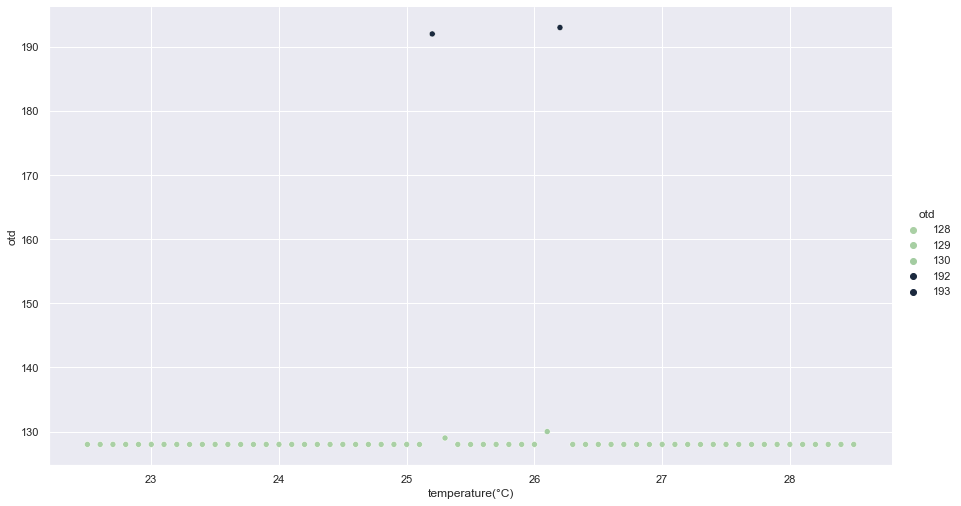

In [33]:
plt.rcParams["figure.figsize"] = (10, 17)
ogt.drawOtdValue()

## exmine with other model

### examine max prediction

In [44]:
y_pred_pmv = np.array(df_max['pmv_temp_max'])

In [45]:
y_pred_pmv

array([29.4, 30.7, 30.6, 30.6, 30.7, 30.6, 32. , 30.7, 30.9])

In [52]:
X = df_max[X_columns]
y_true = np.array(df_max['env_temp'])

In [54]:
y_true = np.array([convertFahrenheitToCelsius(f) for f in y_true])

In [55]:
y_true

array([26.37777778, 27.17277778, 25.91388889, 27.235     , 26.81777778,
       22.60888889, 26.37777778, 26.37777778, 24.84722222])

In [47]:
y_pred_rf = rfr_max.predict(X)

In [49]:
y_pred_rf = np.array([convertFahrenheitToCelsius(f) for f in y_pred_rf])

In [50]:
y_pred_rf

array([26.38098667, 27.14169259, 25.99573852, 26.96327   , 26.89413704,
       24.80595074, 26.07075704, 26.75300185, 26.03961778])

#### max - mse

In [58]:
# mean squared error
mse_rf = mean_squared_error(y_true, y_pred_rf)
mse_pmv = mean_squared_error(y_true, y_pred_pmv)
display(mse_rf)
display(mse_pmv)

0.7301429621923039

24.523844307270256

In [59]:
# drop ratio
(mse_pmv - mse_rf) / mse_pmv

0.970227222410809

#### max - r2

In [61]:
# R2 score
r2_rf = r2_score(y_true, y_pred_rf)
r2_pmv = r2_score(y_true, y_pred_pmv)
display(r2_rf)
display(r2_pmv)

0.6094406330715989

-12.118002368384815

### examine min prediction

In [44]:
y_pred_pmv = np.array(df_max['pmv_temp_max'])

In [45]:
y_pred_pmv

array([29.4, 30.7, 30.6, 30.6, 30.7, 30.6, 32. , 30.7, 30.9])

In [52]:
X = df_min[X_columns]
y_true = np.array(df_min['env_temp'])

In [54]:
y_true = np.array([convertFahrenheitToCelsius(f) for f in y_true])

In [55]:
y_true

array([26.37777778, 27.17277778, 25.91388889, 27.235     , 26.81777778,
       22.60888889, 26.37777778, 26.37777778, 24.84722222])

In [47]:
y_pred_rf = rfr_max.predict(X)

In [49]:
y_pred_rf = np.array([convertFahrenheitToCelsius(f) for f in y_pred_rf])

In [50]:
y_pred_rf

array([26.38098667, 27.14169259, 25.99573852, 26.96327   , 26.89413704,
       24.80595074, 26.07075704, 26.75300185, 26.03961778])

#### min - mse

In [58]:
# mean squared error
mse_rf = mean_squared_error(y_true, y_pred_rf)
mse_pmv = mean_squared_error(y_true, y_pred_pmv)
display(mse_rf)
display(mse_pmv)

0.7301429621923039

24.523844307270256

In [59]:
# drop ratio
(mse_pmv - mse_rf) / mse_pmv

0.970227222410809

#### min - r2

In [61]:
# R2 score
r2_rf = r2_score(y_true, y_pred_rf)
r2_pmv = r2_score(y_true, y_pred_pmv)
display(r2_rf)
display(r2_pmv)

0.6094406330715989

-12.118002368384815